In [1]:
import jyquickhelper
jyquickhelper.add_notebook_menu(first_level=1, last_level=4, header="Dataset preparation with DatasetPreparator")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import time
import tensorflow as tf
import pandas as pd
import gensim


import p8_util
import p8_util_config
import p9_util


Using TensorFlow backend.


# <font color=blus>1. Data loading</font>

In [5]:
import pandas as pd
df_train = pd.read_csv('./data/train.csv.zip', compression='zip', header=0,\
     sep=',', quotechar='"')
print(df_train.shape)

(1804874, 45)


In [93]:
df_train.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

# <font color=blus>2. Data pre-processing</font>

## <font color=blus> 2.1. Check NAN rate into columns</font>

In [236]:
ser_train_isna = df_train.isna().sum()
ser_train_isna

id                                           0
target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

### <font color=blus> Data description</font>

## <font color=blus> 2.2. Filter features without Nan values</font>

In [95]:
list_colname = [colname for colname, value in ser_train_isna.items() if value == 0]
print("Number of valid columns= {}".format(len(list_colname)))

Number of valid columns= 20


### <font color=blus>Columns are filtered from dataframe</font>

Columns with Nan values are droped : this leads to having 20 features.

In [96]:
df_train_filtered = df_train[list_colname]

df_train_filtered.shape, df_train.shape

((1804874, 20), (1804874, 45))

## <font color=blus>2.3. Target (toxicity) distribution</font>

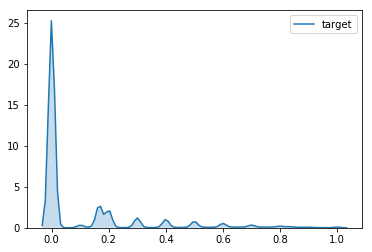

In [126]:
import seaborn as sns
for col in ['target']:
    sns.kdeplot(df_train_filtered[col], shade=True)

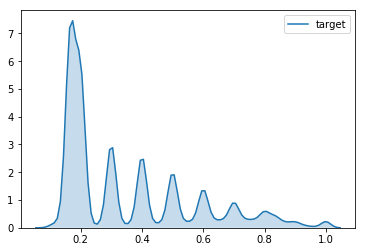

In [189]:
_=sns.kdeplot(ser_text_10pcent, shade=True)

In [226]:
import p9_util

total = df_train_filtered.shape[0]
dict_percent = dict()
verbose = True
for val in range(1,10,1) :
    threshold = val/10
    percent = p9_util.print_col_stat(df_train_filtered, col,threshold, verbose=verbose)
    if verbose :
        print()
    dict_percent[val] = percent
    

Number of texts where toxicity > 0.1 : 524054
Percentage of texts where toxicity > 0.1 : 0.290355

Number of texts where toxicity > 0.2 : 270194
Percentage of texts where toxicity > 0.2 : 0.149702

Number of texts where toxicity > 0.3 : 206991
Percentage of texts where toxicity > 0.3 : 0.114684

Number of texts where toxicity > 0.4 : 151463
Percentage of texts where toxicity > 0.4 : 0.083919

Number of texts where toxicity > 0.5 : 106438
Percentage of texts where toxicity > 0.5 : 0.058973

Number of texts where toxicity > 0.6 : 72235
Percentage of texts where toxicity > 0.6 : 0.040022

Number of texts where toxicity > 0.7 : 45451
Percentage of texts where toxicity > 0.7 : 0.025182

Number of texts where toxicity > 0.8 : 23802
Percentage of texts where toxicity > 0.8 : 0.013188

Number of texts where toxicity > 0.9 : 7517
Percentage of texts where toxicity > 0.9 : 0.004165



In [227]:
pd.Series(dict_percent).min()

0.004164833667059307

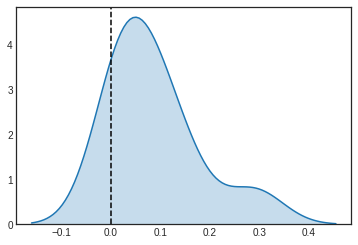

In [228]:
import pandas as pd

_=sns.kdeplot(pd.Series(dict_percent), shade=True)
plt.axvline(0, color="k", linestyle="--");


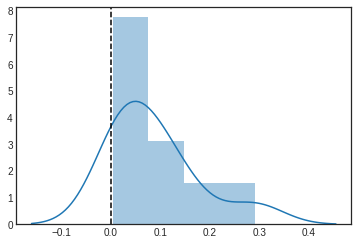

In [229]:
sns.distplot(pd.Series(dict_percent), kde=True);
plt.axvline(0, color="k", linestyle="--");

## <font color=blus>2.4. Extract a test dataset from train file</font>

* Dataset with excluded `Nan` values results in `df_train_filtered` dataframe.
* Features are studied over a fraction of the train dataset (1%) resulting in `df_train_sample`.
* A test dataset is extracted from `df_train_sample` using indexes excluded from `df_train_filtered`. Result is  `df_test_filtered` dataframe.


In [237]:
df_train_sample = df_train_filtered.sample(frac=0.01,random_state=0)
print(df_train_sample.shape)

(18049, 20)


    Get test dataset from indexes into df_train_filtered that do not belongs to train dataset

In [238]:
df_test_filtered = df_train_filtered.query("index!="+str(list(df_train_sample.index)))

    Check consistency after building test dataset and train dataset operations from df_train_filtered.
    It is expected to have equality : Size of train dataset + size of test dataset = size of sample dataset.
    

In [239]:
df_train_filtered.shape[0],df_test_filtered.shape[0] + df_train_sample.shape[0]

(1804874, 1804874)

In [240]:
print(df_train_sample.shape)
print(df_test_filtered.shape)

(18049, 20)
(1786825, 20)


* `df_train_filtered` holds data with excluded `Nan` features values.
* 1% of `df_train_filtered` is used for analysis.
* 30% from `df_test_filtered` is used leading to `df_test_sample`.

In [241]:
# 1% of df_train_filtered is used for analysis.
frac_train = df_train_filtered.shape[0]//100
print("\nNumber rows for analysis train dataset= {}".format(frac_train))

# 30% issued from 1% of df_train_filtered is used for test part analysis.
frac_test = frac_train//3
print("Number rows for analysis test part of dataset= {}".format(frac_test))



Number rows for analysis train dataset= 18048
Number rows for analysis test part of dataset= 6016


In [242]:
df_test_sample = df_test_filtered.sample(n=frac_test,random_state=0)
print(df_test_sample.shape)

(6016, 20)


# <font color=blus>3. Toxicity contributors analysis</font>

* `df_train_part_1` and `df_train_part_2` contain toxicity contributors for analysis.

## <font color=blus>3.1. Multivariate analysis</font>

In [243]:
df_train_part_1 = df_train_sample[['target','severe_toxicity','obscene','identity_attack']]
df_train_part_2 = df_train_sample[['target','insult','threat','sexual_explicit']] 

df_train_part_3 = df_train_sample[['target','funny','wow','sad']]
df_train_part_4 = df_train_sample[['target','likes','disagree']]

/home/bangui/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


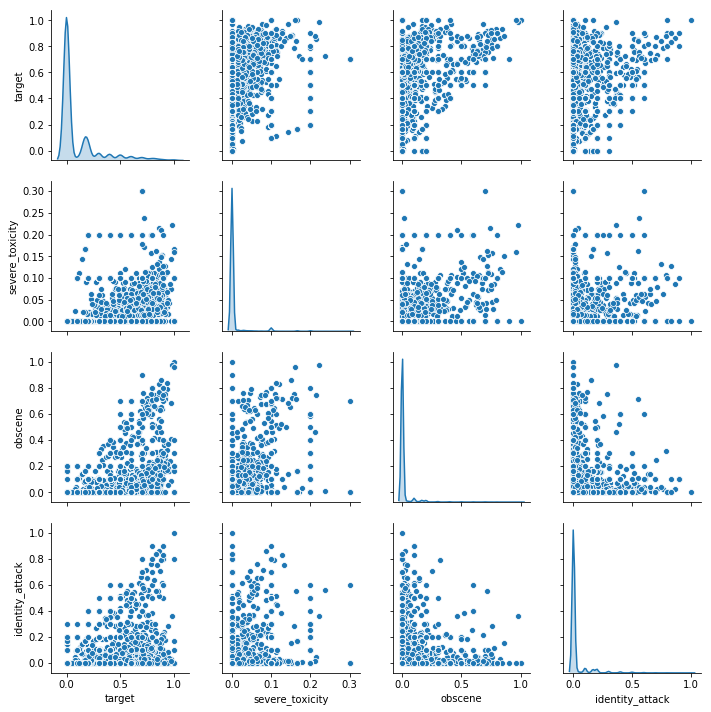

In [13]:
import seaborn as sns
sns.pairplot(df_train_part_1, diag_kind="kde")

/home/bangui/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


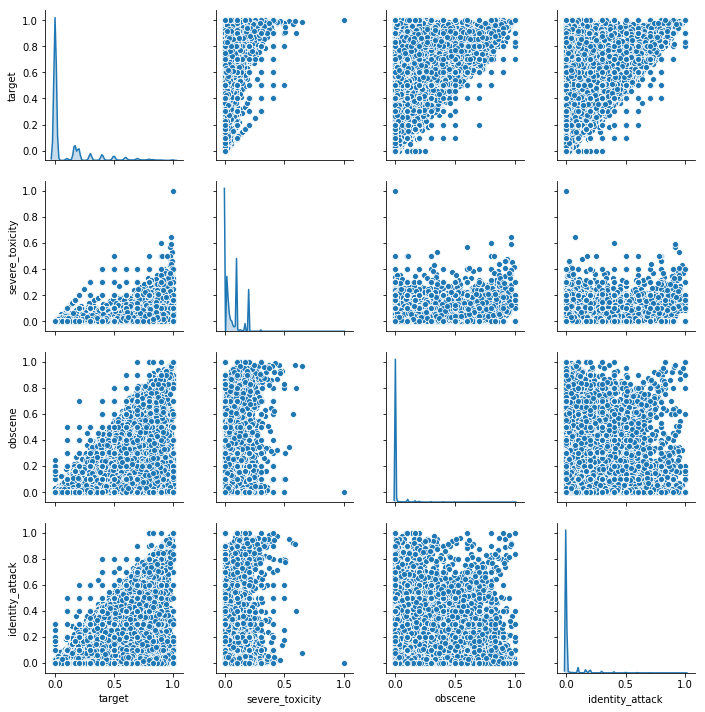

In [46]:
import seaborn as sns
sns.pairplot(df_train_part_1, diag_kind="kde")

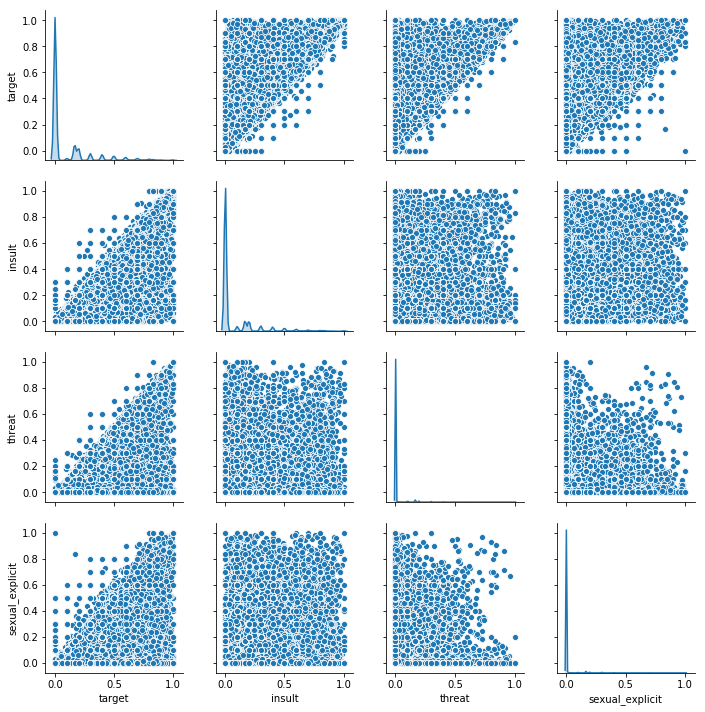

In [47]:
import seaborn as sns
sns.pairplot(df_train_part_2, diag_kind="kde")

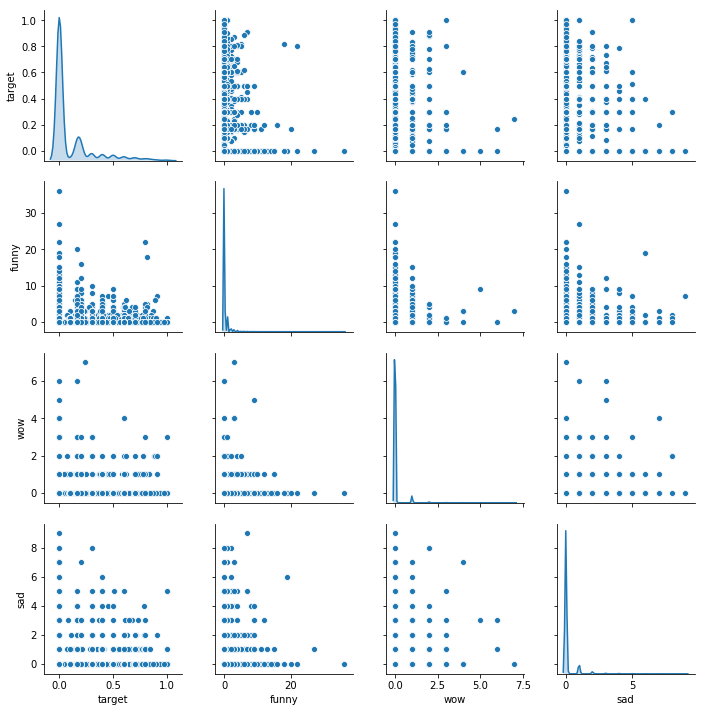

In [256]:
import seaborn as sns
sns.pairplot(df_train_part_3, diag_kind="kde")

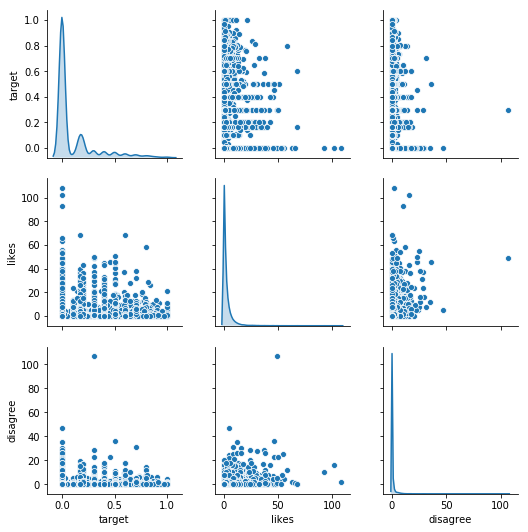

In [257]:
import seaborn as sns
sns.pairplot(df_train_part_4, diag_kind="kde")

## <font color=blus>3.1. Feature engineering : `new_feature`</font>

Combinaison of features that contribute to toxicity detection and forming `new_feature` shows that rectangle-triangle is replaced with a shape in which linear correlation between `target` and `new_feature` is more obvious.

All features does not contribute with the same weight to the toxicity.

`new_feature` is then formed from weights issued from correlations matrix.


### <font color=blus>Features to toxicity contribution are filtered</font>

* Result lies on dataframe `df_train_sample`

In [103]:
list_feature_excluded = ['comment_text','created_date','publication_id','article_id','identity_annotator_count','toxicity_annotator_count']
list_feature_excluded +=['rating','funny','wow','sad','likes','disagree']
list_feature_excluded

['comment_text',
 'created_date',
 'publication_id',
 'article_id',
 'identity_annotator_count',
 'toxicity_annotator_count',
 'rating',
 'funny',
 'wow',
 'sad',
 'likes',
 'disagree']

In [104]:
list_feature = df_train_sample.columns
list_feature = list_feature[1:-1]
list_feature = [feature for feature in list_feature if feature not in list_feature_excluded ]
list_feature

['target',
 'severe_toxicity',
 'obscene',
 'identity_attack',
 'insult',
 'threat',
 'sexual_explicit']

In [271]:
df = df_train_sample[list_feature]
res = df.query('target>0.3').sample(2).head()
print(df_train_sample['comment_text'].loc[res.index[0]])
print()
print(df_train_sample['comment_text'].loc[res.index[1]])
res

So why not worry about the scandal of heterosexual priests?  Why not act against the "straight" sexually active priests and hierarchs with families or girlfriends on the side?  Why not act against the "straight" priests and hierarchs who abuse or hide abusers?  There's been a helluva lot more scandal from that, despite some people's efforts to portray it as a gay issue.  The claim of protecting the Church by keeping gay men out of the seminaries is, bluntly, hypocrisy.

Pathetic. Is that the best the Globe can do?
A drop of (so far) less than 1% is somehow relevant to judge Trump?

How many 1% drops did we have during the Obama years?  

When the market goes down big time, AND IT WILL, it will have little to do with Trump, but with China, Fed policies of the past decade, and a war somewhere that probably is mostly due to Obama's weak leadership in foreign affairs.

By spewing this kind of nonsense, the media enfeeble themselves  and take themselves out of the conversation of serious pe

,target,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
357023,0.400000,0.1,0.100000,0.2,0.300000,0.0,0.0
555712,0.833333,0.0,0.166667,0.0,0.833333,0.0,0.0


The sore losers will be out heavy on this one. The truth drives them batty. Say... come on now king kong... er i mean waveloser. Lets hear your brilliant analysis. Wootwoot!!!!

I only got the email notification which said something about Smug. I believe in full disclosure - just so all our presuppositions are on the table. Yes I am a white, Christian, conservative male - just the type you most likely spent most of your years persecuting. You use a clearly isolated incident with the EPD, and ignore the hundreds of thousands of good things they do. Pretty pathetic if you ask me, and the taxpayers are paying you for this as well. SAD


In [272]:
len("I only got the email notification which said something about Smug. I believe in full disclosure - just so all our presuppositions are on the table. Yes I am a white, Christian, conservative male - just the type you most likely spent most of your years persecuting. You use a clearly isolated incident with the EPD, and ignore the hundreds of thousands of good things they do. Pretty pathetic if you ask me, and the taxpayers are paying you for this as well. SAD")

461

In [105]:
df_train_sample = df_train_sample[list_feature]

###  <font color=blus>Feature engineering : building `new_feature`</font>

* Features such as : 
    * `threat, insult, sexual_explicit, identity_attack, obscene, severe_toxicity` 
  are combined all-together forming to a new feature.

* Those features do contribute to toxicity text detection.

* Those features draw a rectangle-triangle compared with `target` column.

* A linear correlation relation is suspected between those features and ̀`target`. 

In a first step, all weights are fixed to 1. It is supposed that all those features have the same weight considering target value.

Weights are handled into `ser_weight_unit` Series.


In [106]:
import numpy as np
import pandas as pd

df_train_sample.shape
arr_unit = np.array([1. for value in list_feature])
ser_weight_unit =pd.Series( arr_unit, index=list_feature)
print(ser_weight_unit)

target             1.0
severe_toxicity    1.0
obscene            1.0
identity_attack    1.0
insult             1.0
threat             1.0
sexual_explicit    1.0
dtype: float64


* `df_train_sample` is added with a new column named `new_feature`. This new feature is the combination of all other columns with weight values to 1.

In [112]:
import p9_util

df_train_sample = p9_util.df_weight_newFeature(df_train_sample, ser_weight_unit, list_feature, 'new_feature')
print()
print(df_train_sample.columns)
print(df_train_sample.shape)

target 1.0
severe_toxicity 1.0
obscene 1.0
identity_attack 1.0
insult 1.0
threat 1.0
sexual_explicit 1.0

Index(['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult',
       'threat', 'sexual_explicit', 'new_feature'],
      dtype='object')
(18049, 8)


In [108]:
df_train_sample['new_feature'].max()

1.0


Pearson coefficient between (target,new_feature) = 0.9772645985025511


/home/bangui/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


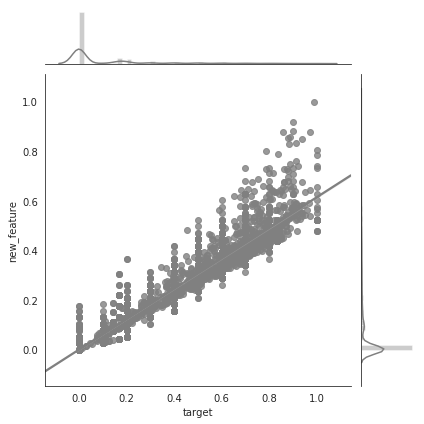

In [109]:
import scipy

import p3_util_plot

var1 = 'target'
var2 = 'new_feature'

pearson = scipy.stats.pearsonr(df_train_sample[var1],df_train_sample[var2])
print("\nPearson coefficient between ({},{}) = {}".format(var1,var2, pearson[0]))

#p3_util_plot.df_sns_joint_plot(df_train_sample, var1, var2, parameter_kind='reg', parameter_color='grey')
p3_util_plot.df_sns_joint_plot(df_train_sample, var1, var2, parameter_color='grey')


Displaying density distributions give additional interpretation.

Features are correlated strongly in interval `[0.0 , 0.2]`


Pearson coefficient between (target,new_feature) = 0.9772645985025511


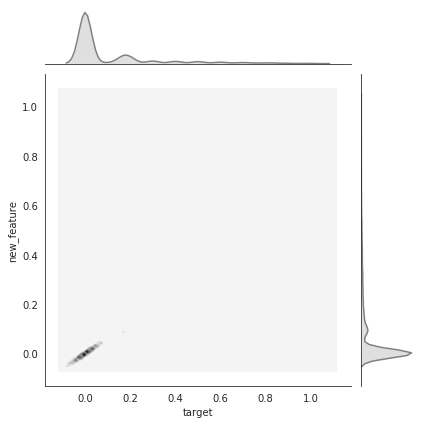

In [26]:
import scipy
import p3_util_plot
var1 = 'target'
var2 = 'new_feature'

pearson = scipy.stats.pearsonr(df_train_sample[var1],df_train_sample[var2])
print("\nPearson coefficient between ({},{}) = {}".format(var1,var2, pearson[0]))

p3_util_plot.df_sns_joint_plot(df_train_sample, var1, var2, parameter_kind='kde', parameter_color='grey')

Then let's plot target values >0.2 and target values <= 0.2

This is achieved applying query to `df_train_sample` dataframe.

In [29]:
select="target <= 0.2"
df_train_sample_select_0 = df_train_sample.query(select, inplace=False)

select="target > 0.2"
df_train_sample_select_1 = df_train_sample.query(select, inplace=False)



Pearson coefficient between (target,new_feature) = 0.929778393032554


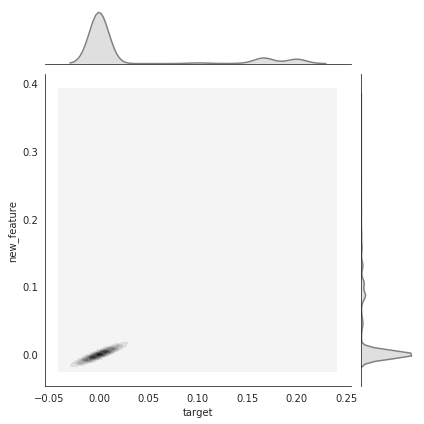

In [30]:
import scipy
import p3_util

pearson = scipy.stats.pearsonr(df_train_sample_select_0[var1],df_train_sample_select_0[var2])
print("\nPearson coefficient between ({},{}) = {}".format(var1,var2, pearson[0]))
p3_util_plot.df_sns_joint_plot(df_train_sample_select_0, var1, var2, parameter_kind='kde', parameter_color='grey')


Pearson coefficient between (target,new_feature) = 0.9035771413019859


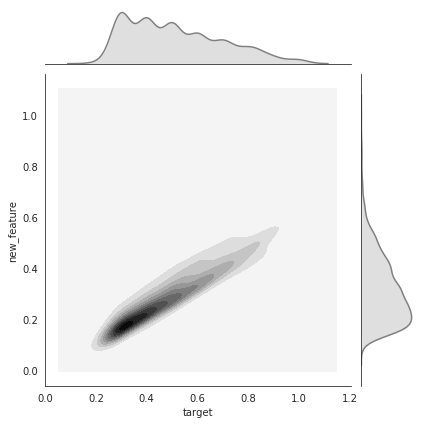

In [31]:
import scipy
import p3_util

pearson = scipy.stats.pearsonr(df_train_sample_select_1[var1],df_train_sample_select_1[var2])
print("\nPearson coefficient between ({},{}) = {}".format(var1,var2, pearson[0]))
p3_util_plot.df_sns_joint_plot(df_train_sample_select_1, var1, var2, parameter_kind='kde', parameter_color='grey')

## <font color=blus>Weighting features with matrix correlations</font>

In [32]:
df_train_sample.max()

target             1.0
severe_toxicity    0.3
obscene            1.0
identity_attack    1.0
insult             1.0
threat             1.0
sexual_explicit    1.0
new_feature        1.0
dtype: float64

In [33]:
if 'new_feature' in df_train_sample :
    del(df_train_sample['new_feature'])

In [34]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
print(std_scaler.fit(df_train_sample))

X_std = std_scaler.transform(df_train_sample)

StandardScaler(copy=True, with_mean=True, with_std=True)


In [35]:
df_train_sample.columns

Index(['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult',
       'threat', 'sexual_explicit'],
      dtype='object')

In [36]:
df_train_sample_std = pd.DataFrame(X_std, columns=df_train_sample.columns)

In [37]:
df_train_sample_std.head(3)

,target,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,-0.527767,-0.209535,-0.215539,-0.288058,-0.466598,-0.190872,-0.136735
1,-0.527767,-0.209535,-0.215539,-0.288058,-0.466598,-0.190872,-0.136735
2,-0.527767,-0.209535,-0.215539,-0.288058,-0.466598,-0.190872,-0.136735


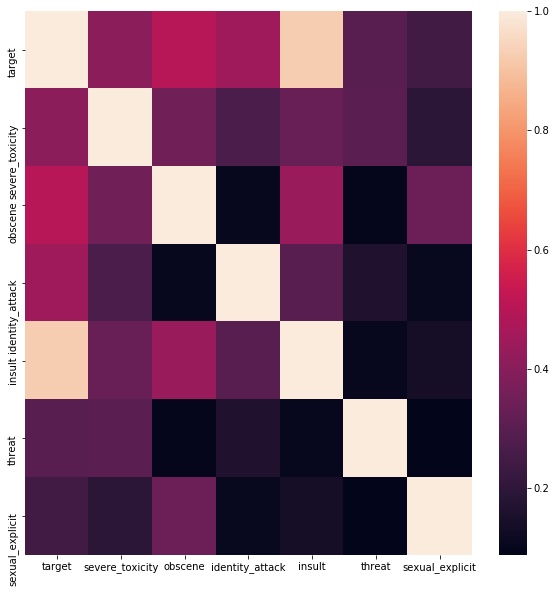

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

X_std_corr = df_train_sample_std.corr()
f, ax = plt.subplots(figsize=(10, 10))
_z = sns.heatmap(X_std_corr, annot=False)

In [45]:
X_std_corr[:]

,target,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
target,1.000000,0.405802,0.500494,0.448081,0.925399,0.296270,0.244588
severe_toxicity,0.405802,1.000000,0.352787,0.267649,0.333349,0.303908,0.193290
obscene,0.500494,0.352787,1.000000,0.104657,0.438020,0.096228,0.338451
identity_attack,0.448081,0.267649,0.104657,1.000000,0.295346,0.164630,0.107064
insult,0.925399,0.333349,0.438020,0.295346,1.000000,0.104562,0.139459
threat,0.296270,0.303908,0.096228,0.164630,0.104562,1.000000,0.087756
sexual_explicit,0.244588,0.193290,0.338451,0.107064,0.139459,0.087756,1.000000


#### Weights assignement for building `new_feature`

Weights are issued from correlation matrix.

In [49]:
list_feature

['target',
 'severe_toxicity',
 'obscene',
 'identity_attack',
 'insult',
 'threat',
 'sexual_explicit']

In [50]:
X_std_corr['target']

target             1.000000
severe_toxicity    0.405802
obscene            0.500494
identity_attack    0.448081
insult             0.925399
threat             0.296270
sexual_explicit    0.244588
Name: target, dtype: float64

In [51]:
df_train_filtered_sample = df_weight_newFeature(df_train_sample, X_std_corr['target'], list_feature, 'new_feature')

target 1.0
severe_toxicity 0.40580207453035044
obscene 0.5004938914679019
identity_attack 0.44808065477165393
insult 0.9253985594798301
threat 0.29627000932665676
sexual_explicit 0.24458800527543303


In [52]:
df_train_filtered_sample['new_feature'].min(), df_train_filtered_sample['new_feature'].max()

(0.0, 1.0)


Pearson coefficient between (target,new_feature) = 0.9897087258200451


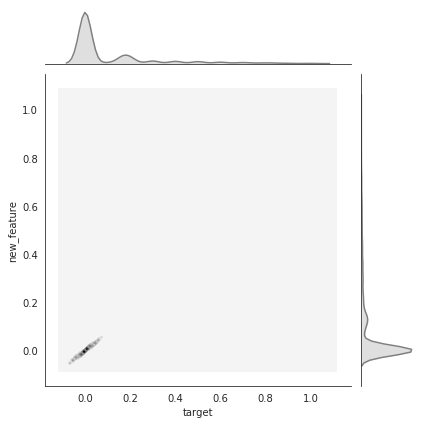

In [53]:
import scipy

import p3_util_plot
var1='target'
var2 = 'new_feature'

pearson = scipy.stats.pearsonr(df_train_filtered_sample[var1],df_train_filtered_sample[var2])
print("\nPearson coefficient between ({},{}) = {}".format(var1,var2, pearson[0]))
p3_util_plot.df_sns_joint_plot(df_train_filtered_sample, var1, var2, parameter_kind='kde', parameter_color='grey')

Using correlation matrix for weighting features when building `new_feature` improve global correlation between 
`new_feature` and `target` (0.989 vs 0.977).

#### Display Pearson coefficient between all features against `target`

In [83]:
df_train_filtered_sample.columns

Index(['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat',
       'sexual_explicit'],
      dtype='object')

In [55]:
import scipy
import p3_util_plot

var1 = 'target'
for var2 in df_train_filtered_sample.columns :
    if var2 != 'target' :
        #p3_util_plot.df_sns_joint_plot(df_train_filtered_sample, var1, var2, parameter_kind='reg', parameter_color='grey')


        pearson = scipy.stats.pearsonr(df_train_filtered_sample[var1],df_train_filtered_sample[var2])
        print("\nPearson coefficient between ({},{}) = {}".format(var1,var2, pearson[0]))
    else :
        pass


Pearson coefficient between (target,severe_toxicity) = 0.4058020745302237

Pearson coefficient between (target,obscene) = 0.5004938914680612

Pearson coefficient between (target,identity_attack) = 0.448080654771592

Pearson coefficient between (target,insult) = 0.9253985594798431

Pearson coefficient between (target,threat) = 0.29627000932655323

Pearson coefficient between (target,sexual_explicit) = 0.2445880052754865

Pearson coefficient between (target,new_feature) = 0.9897087258200451


#### Correlation between `insult` and `target`

/home/bangui/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



Pearson coefficient between (target,insult) = 0.9253985594798431


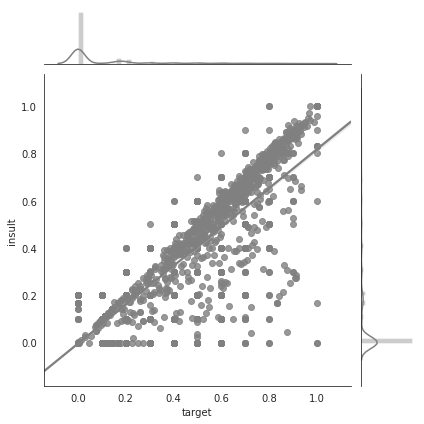

In [56]:
import scipy
import p3_util_plot

var1 = 'target'
var2 = 'insult'
p3_util_plot.df_sns_joint_plot(df_train_filtered_sample, var1, var2, parameter_kind='reg', parameter_color='grey')


pearson = scipy.stats.pearsonr(df_train_filtered_sample[var1],df_train_filtered_sample[var2])
print("\nPearson coefficient between ({},{}) = {}".format(var1,var2, pearson[0]))

In [82]:
df_train_filtered_sample.columns

Index(['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat',
       'sexual_explicit'],
      dtype='object')

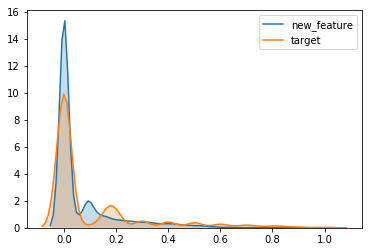

In [116]:
import seaborn as sns
for col in ['new_feature','target']:
    sns.kdeplot(df_train_sample[col], shade=True)

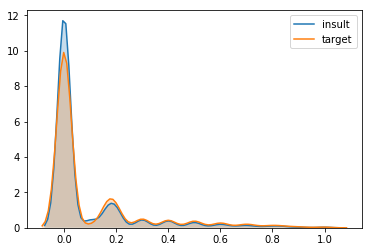

In [118]:
import seaborn as sns
for col in ['insult','target']:
    sns.kdeplot(df_train_sample[col], shade=True)

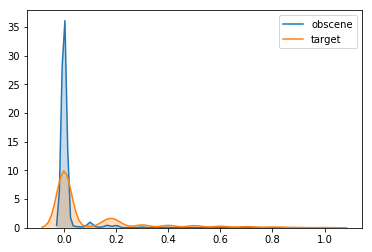

In [119]:
import seaborn as sns
for col in ['obscene','target']:
    sns.kdeplot(df_train_sample[col], shade=True)

In [115]:
df_train_sample.columns

Index(['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult',
       'threat', 'sexual_explicit', 'new_feature'],
      dtype='object')

### Weights issued from a linear regression

#### Target is extracted from dataframe

Dataframe keeps features used only for linear regression.

In [57]:
df_train_sample.columns

Index(['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult',
       'threat', 'sexual_explicit', 'new_feature'],
      dtype='object')

In [58]:
if 'target' in df_train_sample.columns:
    df_train_label = df_train_sample.pop('target')

if 'new_feature' in df_train_sample.columns:
    del(df_train_sample['new_feature'])

In [59]:
df_train_sample.shape

(18049, 6)

#### Data is standardized

In [60]:
from sklearn.preprocessing import StandardScaler
if False :
    std_scaler = StandardScaler()
    print(std_scaler.fit(df_train_sample))

    X_std = std_scaler.transform(df_train_sample)
else :
    X_std = df_train_sample.copy()

#### Linear regression model is built

In [61]:
from sklearn.linear_model import LinearRegression

model_regression = LinearRegression().fit(X_std, df_train_label)

#### Displaying correlation coefficient

Coefficient issued from linear regression and  those issued from matrix correlation are both displayed.

Some of them have closed values, such as `threat` and `identity_attack`, others strongly differ.

In [62]:
for feature, lr_coef, corr_coef in zip(df_train_sample.columns, model_regression.coef_,X_std_corr['target'][1:]):
    print("Feature: {} : linear regression coeff= {} / Correlation matrix coeff= {}".format(feature, lr_coef, corr_coef))

Feature: severe_toxicity : linear regression coeff= -0.05362561443422439 / Correlation matrix coeff= 0.40580207453035044
Feature: obscene : linear regression coeff= 0.2619629875316454 / Correlation matrix coeff= 0.5004938914679019
Feature: identity_attack : linear regression coeff= 0.40888237843007297 / Correlation matrix coeff= 0.44808065477165393
Feature: insult : linear regression coeff= 0.9155839990091565 / Correlation matrix coeff= 0.9253985594798301
Feature: threat : linear regression coeff= 0.6734955460989804 / Correlation matrix coeff= 0.29627000932665676
Feature: sexual_explicit : linear regression coeff= 0.31847938964928624 / Correlation matrix coeff= 0.24458800527543303


In [69]:
df_test_sample.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'created_date', 'publication_id',
       'article_id', 'rating', 'funny', 'wow', 'sad', 'likes', 'disagree',
       'sexual_explicit', 'identity_annotator_count',
       'toxicity_annotator_count'],
      dtype='object')

In [70]:
if 'target' in df_test_sample.columns : 
    df_test_target = df_test_sample.pop('target')
df_test_sample.columns

Index(['id', 'comment_text', 'severe_toxicity', 'obscene', 'identity_attack',
       'insult', 'threat', 'created_date', 'publication_id', 'article_id',
       'rating', 'funny', 'wow', 'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [71]:
list_feature
if 'target' in list_feature :
    list_feature.remove('target')
print(list_feature)

['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']


In [72]:
df_test_sample = df_test_sample[list_feature]

In [ ]:
X_std = std_scaler.transform(df_test_sample)

In [76]:
model_regression.score(X_std, df_test_target)

-48.750536382222116

### <font color=blus>Distribution of `target` from test dataset</font>

In [122]:
df_test_sample.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'created_date', 'publication_id',
       'article_id', 'rating', 'funny', 'wow', 'sad', 'likes', 'disagree',
       'sexual_explicit', 'identity_annotator_count',
       'toxicity_annotator_count'],
      dtype='object')

In [123]:
import numpy as np
import pandas as pd

df_train_sample.shape
arr_unit = np.array([1. for value in list_feature])
ser_weight_unit =pd.Series( arr_unit, index=list_feature)
print(ser_weight_unit)

target             1.0
severe_toxicity    1.0
obscene            1.0
identity_attack    1.0
insult             1.0
threat             1.0
sexual_explicit    1.0
dtype: float64


In [124]:
import p9_util

df_test_sample = p9_util.df_weight_newFeature(df_test_sample, ser_weight_unit, list_feature, 'new_feature')
print()
print(df_test_sample.columns)
print(df_test_sample.shape)

target 1.0
severe_toxicity 1.0
obscene 1.0
identity_attack 1.0
insult 1.0
threat 1.0
sexual_explicit 1.0

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'created_date', 'publication_id',
       'article_id', 'rating', 'funny', 'wow', 'sad', 'likes', 'disagree',
       'sexual_explicit', 'identity_annotator_count',
       'toxicity_annotator_count', 'new_feature'],
      dtype='object')
(6016, 21)


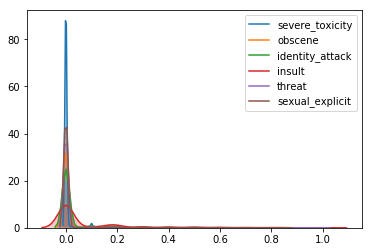

In [74]:
import seaborn as sns

for col in df_test_sample.columns:
    sns.kdeplot(df_test_sample[col], shade=True)

This display shows a long trail above 0.2 `target` column is added to `df_test_sample`. 

This will allow to extract a subset of `df_test_sample` 
filtered with `target` >0.2

In [75]:
if 'target' not in df_test_sample.columns:
    df_test_sample['target'] = df_test_target

df_test_sample_filtered = df_test_sample.query('target<0.2')

In [76]:
df_test_sample_filtered.columns

Index(['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat',
       'sexual_explicit', 'target'],
      dtype='object')

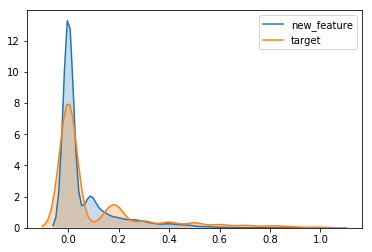

In [125]:
import seaborn as sns

for col in ['new_feature','target']:
    z_ = sns.kdeplot(df_test_sample[col], shade=True)


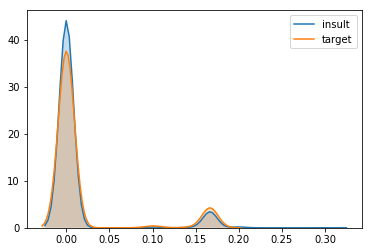

In [79]:
import seaborn as sns

for col in ['insult','target']:
    z_ = sns.kdeplot(df_test_sample_filtered[col], shade=True)

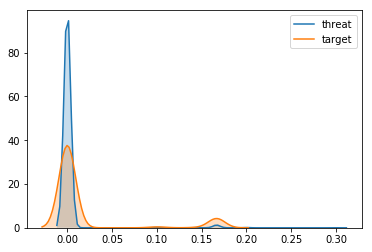

In [430]:
import seaborn as sns

for col in ['threat','target']:
    z_ = sns.kdeplot(df_test_sample_filtered[col], shade=True)

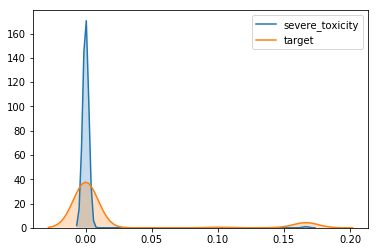

In [431]:
import seaborn as sns

for col in ['severe_toxicity','target']:
    z_ = sns.kdeplot(df_test_sample_filtered[col], shade=True)

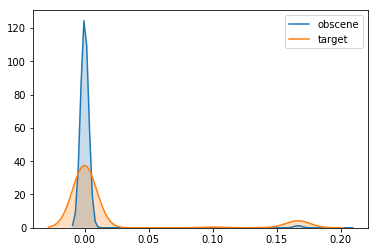

In [432]:
import seaborn as sns

for col in ['obscene','target']:
    z_ = sns.kdeplot(df_test_sample_filtered[col], shade=True)

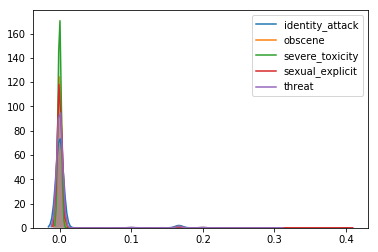

In [433]:
import seaborn as sns

for col in ['identity_attack','obscene', 'severe_toxicity','sexual_explicit','threat']:
    z_ = sns.kdeplot(df_test_sample_filtered[col], shade=True)

In [436]:
from scipy.stats import kstest
col='insult'
kstest(df_test_sample_filtered[col], 'norm')

KstestResult(statistic=0.5, pvalue=0.0)

### <font color=blus>Distribution of `target` from train dataset</font>

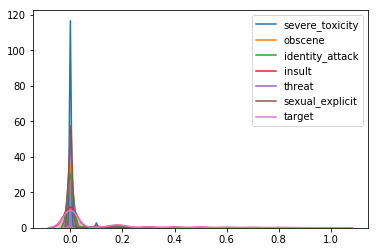

In [439]:
import seaborn as sns

for col in df_train_sample.columns:
    sns.kdeplot(df_train_sample[col], shade=True)

In [455]:
if 'target' not in df_train_sample.columns:
    df_train_sample['target'] = df_train_label

df_train_sample_filtered = df_train_sample.query('target>0.1')
df_train_sample_filtered.shape, df_train_sample.shape

((5296, 7), (18049, 7))

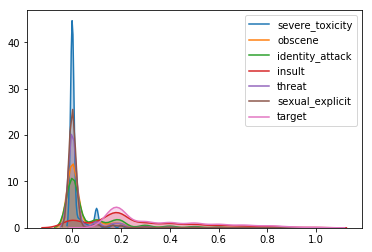

In [456]:
import seaborn as sns

for col in df_train_sample_filtered.columns:
    sns.kdeplot(df_train_sample_filtered[col], shade=True)

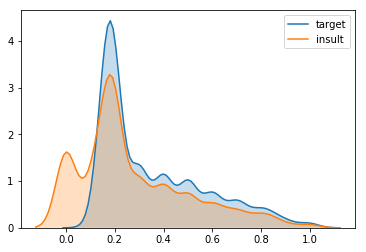

In [457]:
import seaborn as sns

for col in ['target','insult'] :
    sns.kdeplot(df_train_sample_filtered[col], shade=True)

    We can conclude that insult contributes the most to a toxic comment

In [121]:
df_test_sample.shape, df_train_sample.shape

((6016, 20), (18049, 8))